In [1]:
import os
import xml.etree.ElementTree as et
import re
import pandas as pd
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Parses each annotation xml file into a table with an entry for each image.
# Each pictured individual should be listed along with their respective mask state.
# This compiles the image annotations in a way that we can apply them to an image file
def generate_csv_data(path):
    print("generating csv table for path: ", path)
    dictionary = {"image": [], "Dimensions": []}
    for i in range(1, 116):
        dictionary[f'Object {i}'] = []
    for file in os.listdir(path):
        row = []
        root = et.parse(path+"\\"+file).getroot()
        img = root[1].text
        row.append(img)
        h, w = root[2][0].text,root[2][1].text
        row.append([h,w])
        for i in range(4,len(root)):
            temp = []
            temp.append(root[i][0].text)
            for point in root[i][5]:
                temp.append(point.text)
            row.append(temp)
        for i in range(len(row), 119):
            row.append(0)
        for i,each in enumerate(dictionary):
            dictionary[each].append(row[i])
    return pd.DataFrame(dictionary)

# Uses an annotation dictionary to create lists of input and ouptput data for the machine learning model
# Each entry in the input list is a face from an image. Each entry in the output list is the mask state of the face
def extract_faces(imageDir, dictionary, states):
    labels = []
    data = []
    imageDirs = sorted(glob.glob(os.path.join(imageDir,"*.png")))
    print("begin extract_faces...")
    for idx, image in enumerate(imageDirs):
        img  = cv2.imread(image)
        img_x, img_y = dictionary["Dimensions"][idx]
        cv2.resize(img, (int(img_x), int(img_x)))
        # create an entry for each face in each photo
        for obj in dictionary.columns[3:]:
            info = dictionary[obj][idx]
            if info == 0:
                continue
            l = info[0]
            labels.append(l)
            info[0] = info[0].replace(str(l), str(states.index(l)))
            coords = [int(each) for each in info]
            # resize image to bounding box for face and preprocess
            face = cv2.resize(img[coords[2]:coords[4], coords[1]:coords[3]], (224, 224))
            face = preprocess_input(img_to_array(face))
            data.append(face)
            if(l=="mask_weared_incorrect"):
                data.append(face)
                labels.append(l)
    print("extract_faces done")
    return np.array(data, dtype="float32"), np.array(labels)

# construct the deep learning model that will be used to train the data set
def build_model():
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    for layer in baseModel.layers:
        layer.trainable = False
    return model

# fit the training data and validate against test data on the model
def train_model(model, trainX, testX, trainY, testY, ep, lr, bs):
    dg = ImageDataGenerator(zoom_range=0.1, rotation_range=25, width_shift_range=0.1,height_shift_range=0.1,shear_range=0.15,horizontal_flip=True)
    print("train_model started...")
    opt = Adam(learning_rate=lr) # Adam is the deep learning algorithm
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    # train the head of the network
    print("training head...")
    return model.fit(
        dg.flow(trainX, trainY, batch_size=bs),
        steps_per_epoch=len(trainX) // bs,
        validation_data=(testX, testY),
        validation_steps=len(testX) // bs,
        epochs=ep)

# Plot training results after each iteration
def plt_stats(epochs, numEpochs):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, numEpochs), epochs.history["loss"], label="train_loss")
    plt.plot(np.arange(0, numEpochs), epochs.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, numEpochs), epochs.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, numEpochs), epochs.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

# plots a confusion matrix using actual and predicted outputs
def plt_confusion_matrix(yTest, yPred, title = 'Confusion Matrix'):
    cm = confusion_matrix(yTest, yPred)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    plt.show()

generating csv table for path:  C:\Users\logan\AppData\Local\Programs\Python\Python39\Scripts\Project\annotations
begin extract_faces...
extract_faces done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number faces:  3306
with_mask


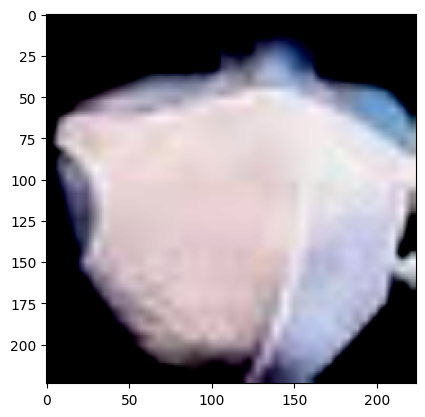

In [2]:
imagePath = r'C:\Users\logan\AppData\Local\Programs\Python\Python39\Scripts\Project\images'
annotationPath = r'C:\Users\logan\AppData\Local\Programs\Python\Python39\Scripts\Project\annotations'
maskStates = ["without_mask","mask_weared_incorrect","with_mask"] # 3 possible states

# compile the image data and parse into input (data) and output (labels) values
dataTable = generate_csv_data(annotationPath)
data, labels = extract_faces(imagePath, dataTable, maskStates)

# Now that we have the data compiled, display an example image and mask state
print("Number faces: ", len(data))
print(labels[0])
plt.imshow(data[0])

In [3]:
# Convert string values to categorical for model training
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# split data into test and train sets to evalutate the model with
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
numEpochs = 25
# build and execute model
model = build_model()
epochs = train_model(model, trainX, testX, trainY, testY, numEpochs, 1e-4, 1)

train_model started...
training head...
Epoch 1/25
2314/2314 [==============================] - 67s 28ms/step - loss: 0.5504 - accuracy: 0.7995 - val_loss: 0.4109 - val_accuracy: 0.8609
Epoch 2/25
2314/2314 [==============================] - 64s 28ms/step - loss: 0.4428 - accuracy: 0.8470 - val_loss: 0.3562 - val_accuracy: 0.8770
Epoch 3/25
2314/2314 [==============================] - 65s 28ms/step - loss: 0.3996 - accuracy: 0.8608 - val_loss: 0.3367 - val_accuracy: 0.8760
Epoch 4/25
2314/2314 [==============================] - 64s 28ms/step - loss: 0.3622 - accuracy: 0.8660 - val_loss: 0.3408 - val_accuracy: 0.8740
Epoch 5/25
2314/2314 [==============================] - 64s 28ms/step - loss: 0.3443 - accuracy: 0.8777 - val_loss: 0.3123 - val_accuracy: 0.8891
Epoch 6/25
2314/2314 [==============================] - 63s 27ms/step - loss: 0.3520 - accuracy: 0.8747 - val_loss: 0.3089 - val_accuracy: 0.8881
Epoch 7/25
2314/2314 [==============================] - 65s 28ms/step - loss: 0.3169

using model to predict test data
31/31 [==============================] - 10s 296ms/step
                       precision    recall  f1-score   support

mask_weared_incorrect       0.70      0.40      0.51        52
            with_mask       0.94      0.96      0.95       760
         without_mask       0.80      0.83      0.82       180

             accuracy                           0.91       992
            macro avg       0.81      0.73      0.76       992
         weighted avg       0.90      0.91      0.90       992



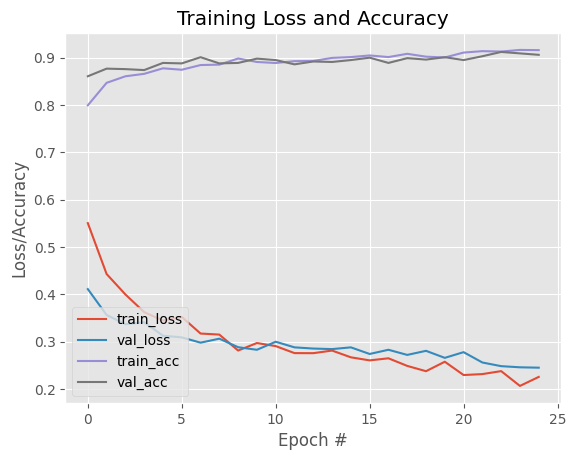

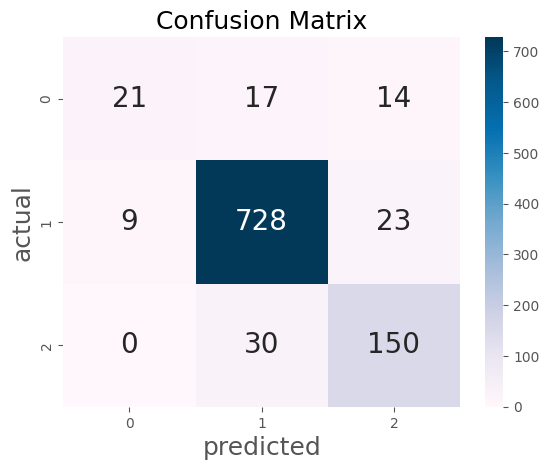

In [4]:
# Now we will use the model to predict output for the test images
# We can compare the results of the predicition against the known output values
# of test images

print("using model to predict test data")
predictedVals = model.predict(testX)
predictedVals = np.argmax(predictedVals, axis=1)
trueVals = testY.argmax(axis=1)

# Generate a report comparing the known values to the predicted values
report = classification_report(trueVals, predictedVals, target_names=lb.classes_)
print(report)
plt_stats(epochs, numEpochs)
plt_confusion_matrix(trueVals, predictedVals)

In [ ]:
# Throughout each of the training epochs the model's accuracy continued to rise.
# After consuming the test data, we are able to see through the confusion matrix 
#   and classification report that the model is able to accurately predict a face mask state.

In [5]:
# As a demonstration, choose a number of random faces and compare a predicted result with an actual
print("Mask states: ",maskStates,"\n")
for i in range(0, 10):
    x = random.randint(0, len(data)-1)
    p = model.predict(data[x:x+1])
    p = np.argmax(p, axis=1)
    print("Index: ", x)
    print("Actual: ", labels[x])
    print("Predicted: ", maskStates[p[0]])

Mask states:  ['without_mask', 'mask_weared_incorrect', 'with_mask'] 

1/1 [==============================] - 1s 605ms/step
Index:  29
Actual:  [0. 1. 0.]
Predicted:  mask_weared_incorrect
1/1 [==============================] - 0s 38ms/step
Index:  1525
Actual:  [0. 1. 0.]
Predicted:  mask_weared_incorrect
1/1 [==============================] - 0s 38ms/step
Index:  2142
Actual:  [0. 1. 0.]
Predicted:  mask_weared_incorrect
1/1 [==============================] - 0s 36ms/step
Index:  1614
Actual:  [0. 1. 0.]
Predicted:  mask_weared_incorrect
1/1 [==============================] - 0s 36ms/step
Index:  2776
Actual:  [0. 0. 1.]
Predicted:  with_mask
1/1 [==============================] - 0s 37ms/step
Index:  2374
Actual:  [0. 1. 0.]
Predicted:  mask_weared_incorrect
1/1 [==============================] - 0s 35ms/step
Index:  719
Actual:  [0. 1. 0.]
Predicted:  mask_weared_incorrect
1/1 [==============================] - 0s 36ms/step
Index:  810
Actual:  [0. 0. 1.]
Predicted:  with_mask
1/1 

In [1]:
# Conclusion
# After training the model, 10 random faces were chosen from among the test data.
# As demonstrated above the model correctly predicted the mask state of each.
# We can see the model is able to accurately predict whether a person is 
#   wearing a mask, wearing a mask incorrectly, or not wearing a mask at all.
#   In addition, this predictions are in line with the results demonstrated by the confusion matrix